# 5.2 (c)
## tensorflow.keras スタイルでプログラミングする p.312

<font color="red">[自分へのメモ]</font>
ImageDataGenerator を使う場合は model.fit() は loss='sparse_categorical_crossentropy' でコンパイルしてはいけない(Bug?)。
loss='categorical_crossentropy' だと動く。

<font color="red">[自分へのメモ(2021/Mar/05 追記)]</font>
上記の件は p.337 の「活用メモ」に記載されていた。

In [1]:
# 5-02-20 CIFAR-10 データセットの読み込み
# p.312

from tensorflow.keras import datasets

(x_train, t_train), (x_test, t_test) = datasets.cifar10.load_data()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [2]:
# 5-02-21 CNN モデルの構築
# p.312
# [自分へのメモ] 本に記載されている元のプログラム

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

weight_decay = 1e-4

model = models.Sequential()

model.add(layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    input_shape=x_train.shape[1:],
    padding='same',
    #kernel_regularizer=regularizers.l2(weight_decay),
    activation='relu'
    ))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(
    filters=128,
    kernel_size=(3, 3),
    padding='same',
    #kernel_regularizer=regularizers.l2(weight_decay),
    activation='relu'
    ))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(
    filters=256,
    kernel_size=(3, 3),
    padding='same',
    #kernel_regularizer=regularizers.l2(weight_decay),
    activation='relu'
    ))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [3]:
# 5-02-21 CNN モデルの構築
# p.312
# [自分へのメモ] 関数呼び出しでモデルを作るように変更した。これで複数のモデルを作成して実験できる。

from tensorflow.keras import models, layers, optimizers, regularizers

def CNN(input_dim, output_dim):
    weight_decay = 1e-4
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=input_dim,padding='same',kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(output_dim,activation='softmax'))
    return model

In [4]:
learning_rate = 0.1

model = CNN(x_train.shape[1:], 10)   # 0次元方向(batch_size)を取り除けば、各データのshapeが得られる

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizers.SGD(lr=learning_rate),
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [5]:
# 5-02-22 拡張処理を行ったデータで学習する
# p.316
# [自分へのメモ]時間を計測する部分は別のセルで実行する

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=64

datagen = ImageDataGenerator(
    rescale = 1.0 / 255.0,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2)

# 学習用
training_generator = datagen.flow(
    x_train,
    t_train,
    batch_size=batch_size,
    subset='training'
    )

# 検証用
validation_generator = datagen.flow(
    x_train,
    t_train,
    batch_size=batch_size,
    subset='validation'
    )

### <font color="red">[自分へのメモ]</font> 
<p>
少なくとも tensorflow 2.3 において、genenratorを使った model.fit() では <font color="red">loss="sparse_categorical_crossentropy" でcompileされていると、まったく学習が進まない</font>ようだ(2020/Mar/05現在)。accuracy が約 0.1 というのは、10クラス分類ではあてずっぽうと同等の精度である。正解ラベルを one hot vector 化 (tensorflow.keras.utils.to_categorical()) して loss="categorical_cross_entropy" を使うと正しく学習できる。
</p>


In [6]:
%%time
epochs=100
#steps = len(x_train)*0.8 / batch_size

history = model.fit(
    training_generator,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator
    )

Epoch 1/100
625/625 [==============================] - 18s 29ms/step - loss: 1.9955 - accuracy: 0.1171 - val_loss: 1.6802 - val_accuracy: 0.0921
Epoch 2/100
625/625 [==============================] - 18s 29ms/step - loss: 1.5833 - accuracy: 0.0950 - val_loss: 1.5674 - val_accuracy: 0.0950
Epoch 3/100
625/625 [==============================] - 18s 29ms/step - loss: 1.4278 - accuracy: 0.0950 - val_loss: 1.3306 - val_accuracy: 0.0749
Epoch 4/100
625/625 [==============================] - 18s 29ms/step - loss: 1.3250 - accuracy: 0.0989 - val_loss: 1.2566 - val_accuracy: 0.0801
Epoch 5/100
625/625 [==============================] - 18s 29ms/step - loss: 1.2330 - accuracy: 0.0979 - val_loss: 1.1996 - val_accuracy: 0.1127
Epoch 6/100
625/625 [==============================] - 18s 29ms/step - loss: 1.1696 - accuracy: 0.0991 - val_loss: 1.0929 - val_accuracy: 0.0914
Epoch 7/100
625/625 [==============================] - 18s 29ms/step - loss: 1.1189 - accuracy: 0.0996 - val_loss: 1.0621 - val_ac

625/625 [==============================] - 18s 29ms/step - loss: 0.5457 - accuracy: 0.1015 - val_loss: 0.7202 - val_accuracy: 0.0934
Epoch 58/100
625/625 [==============================] - 18s 29ms/step - loss: 0.5368 - accuracy: 0.1010 - val_loss: 0.6954 - val_accuracy: 0.1007
Epoch 59/100
625/625 [==============================] - 18s 29ms/step - loss: 0.5332 - accuracy: 0.1013 - val_loss: 0.6898 - val_accuracy: 0.1094
Epoch 60/100
625/625 [==============================] - 18s 29ms/step - loss: 0.5211 - accuracy: 0.1009 - val_loss: 0.6682 - val_accuracy: 0.1056
Epoch 61/100
625/625 [==============================] - 18s 29ms/step - loss: 0.5324 - accuracy: 0.1011 - val_loss: 0.6771 - val_accuracy: 0.1039
Epoch 62/100
625/625 [==============================] - 18s 29ms/step - loss: 0.5310 - accuracy: 0.1010 - val_loss: 0.7050 - val_accuracy: 0.0975
Epoch 63/100
625/625 [==============================] - 18s 29ms/step - loss: 0.5256 - accuracy: 0.0998 - val_loss: 0.6731 - val_accuracy

In [7]:
# 5-02-23 損失と精度の推移をグラフにする
# p.317
# [自分へのメモ] 独自のコードで書き直した

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(6*2, 4))
    
    ax[0].plot(history['accuracy'], "-", label="accuracy",c="blue")
    ax[0].plot(history['val_accuracy'], "-", label="val_accuracy",c="green")
    ax[0].set_title('model accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(loc="lower right")
    
    ax[1].plot(history['loss'], "-", label="loss", c="blue")
    ax[1].plot(history['val_loss'], "-", label="val_loss", c="green")
    ax[1].set_title('model loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(loc="upper left")

    plt.subplots_adjust(wspace=0.1)
    plt.show()

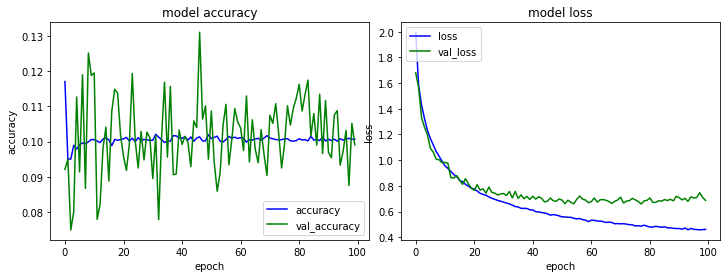

In [8]:
plot_history(history.history)

In [9]:
# 学習結果を評価する
test_loss, test_acc = model.evaluate(x_test/255, t_test, verbose=0)
print(f'test_loss: {test_loss:.4f}  test_acc: {test_acc:.4f}')

test_loss: 0.6630  test_acc: 0.1042


## [自習] loss='categorical_crossentropy'を使う

<font color="blue">[自分へのメモ]</font> generator を使って model.fit() しても正しく学習できる。

In [10]:
t_train_cat = tf.keras.utils.to_categorical(t_train, 10)
t_test_cat = tf.keras.utils.to_categorical(t_test, 10)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size=64

datagen2 = ImageDataGenerator(
    rescale=1.0/255.0, ### [0,1]に正規化
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
    )
datagen2.fit(x_train)
training_generator2 = datagen2.flow(
    x_train,   ### [0,255]
    t_train_cat,
    batch_size=batch_size,
    subset='training'
    )

validation_generator2 = datagen2.flow(
    x_train,   #### [0,255]
    t_train_cat,
    batch_size=batch_size,
    subset='validation'
    )
model2 = CNN(x_train.shape[1:], 10)
model2.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=learning_rate),
    metrics=['accuracy']
    )

In [12]:
%%time
history2=model2.fit(
    training_generator2,
    epochs=100,
    verbose=1,
    validation_data=validation_generator2
    )

Epoch 1/100
625/625 [==============================] - 18s 30ms/step - loss: 1.9755 - accuracy: 0.2882 - val_loss: 1.6348 - val_accuracy: 0.4042
Epoch 2/100
625/625 [==============================] - 18s 29ms/step - loss: 1.5848 - accuracy: 0.4378 - val_loss: 1.4188 - val_accuracy: 0.5044
Epoch 3/100
625/625 [==============================] - 18s 29ms/step - loss: 1.4367 - accuracy: 0.4945 - val_loss: 1.3254 - val_accuracy: 0.5301
Epoch 4/100
625/625 [==============================] - 18s 29ms/step - loss: 1.3247 - accuracy: 0.5367 - val_loss: 1.2847 - val_accuracy: 0.5450
Epoch 5/100
625/625 [==============================] - 18s 29ms/step - loss: 1.2352 - accuracy: 0.5702 - val_loss: 1.2088 - val_accuracy: 0.5723
Epoch 6/100
625/625 [==============================] - 18s 29ms/step - loss: 1.1700 - accuracy: 0.5966 - val_loss: 1.0857 - val_accuracy: 0.6247
Epoch 7/100
625/625 [==============================] - 18s 29ms/step - loss: 1.1186 - accuracy: 0.6180 - val_loss: 1.0814 - val_ac

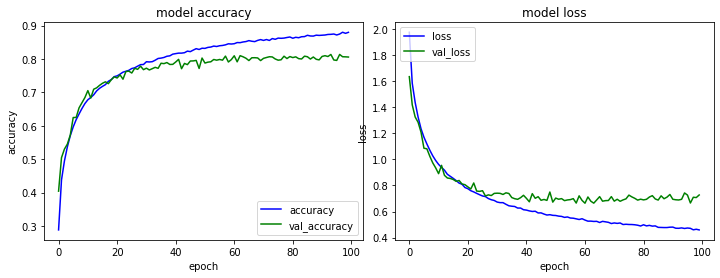

In [13]:
plot_history(history2.history)

In [14]:
# 学習結果を評価する
test_loss, test_acc = model2.evaluate(x_test.astype('float32')/255, t_test_cat, verbose=0)
print(f'test_loss: {test_loss:.4f}  test_acc: {test_acc:.4f}')

test_loss: 0.6208  test_acc: 0.8439


## [自習] 自分で正規化(normalize)するコードを加える

正規化したデータを保持する変数名は <code>x_train_norm</code>, <code>x_test_norm</code> とする。

In [15]:
# normalize
# axis=(0,1,2,3)は全体に対して計算するという指示なので、axisを指定しない場合と同じ意味となる

mean = np.mean(x_train, axis=(0,1,2,3))  # 平均
std = np.std(x_train, axis=(0,1,2,3))    #  標準偏差 (Standard Deviation)

x_train_norm = (x_train - mean) / (std + 1e-7)
x_test_norm = (x_test - mean) / (std + 1e-7)

In [16]:
datagen3 = ImageDataGenerator(
    # rescale = 1.0 / 255.0,  ### 自分で正規化しているので
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2)

# 学習用
training_generator3 = datagen3.flow(
    x_train_norm,
    t_train_cat,
    batch_size=batch_size,
    subset='training'
    )

# 検証用
validation_generator3 = datagen3.flow(
    x_train_norm,
    t_train_cat,
    batch_size=batch_size,
    subset='validation'
    )
model3 = CNN(x_train.shape[1:], 10)
model3.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=learning_rate),
    metrics=['accuracy']
    )

In [17]:
%%time
history3=model3.fit(
    training_generator3,
    epochs=100,
    verbose=1,
    validation_data=validation_generator3
    )

Epoch 1/100
625/625 [==============================] - 18s 29ms/step - loss: 1.7352 - accuracy: 0.3794 - val_loss: 1.5312 - val_accuracy: 0.4756
Epoch 2/100
625/625 [==============================] - 18s 29ms/step - loss: 1.4053 - accuracy: 0.5055 - val_loss: 1.2217 - val_accuracy: 0.5700
Epoch 3/100
625/625 [==============================] - 18s 29ms/step - loss: 1.2495 - accuracy: 0.5656 - val_loss: 1.1521 - val_accuracy: 0.6025
Epoch 4/100
625/625 [==============================] - 18s 29ms/step - loss: 1.1389 - accuracy: 0.6068 - val_loss: 1.0744 - val_accuracy: 0.6367
Epoch 5/100
625/625 [==============================] - 18s 29ms/step - loss: 1.0647 - accuracy: 0.6365 - val_loss: 0.9514 - val_accuracy: 0.6837
Epoch 6/100
625/625 [==============================] - 18s 29ms/step - loss: 1.0074 - accuracy: 0.6587 - val_loss: 0.9426 - val_accuracy: 0.6825
Epoch 7/100
625/625 [==============================] - 18s 29ms/step - loss: 0.9605 - accuracy: 0.6770 - val_loss: 0.9019 - val_ac

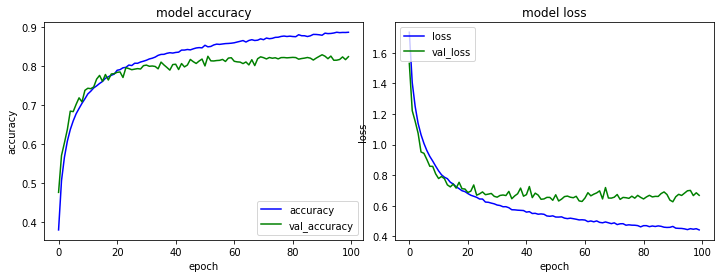

In [18]:
plot_history(history3.history)

In [19]:
# 学習結果を評価する
test_loss, test_acc = model3.evaluate(x_test_norm, t_test_cat, verbose=0)
print(f'test_loss: {test_loss:.4f}  test_acc: {test_acc:.4f}')

test_loss: 0.6348  test_acc: 0.8490


## [自習] generatorの ZCA whitening 機能を使ってみる。

<font color="red">[自分へのメモ]</font> x_test をどう正規化するのが正しい操作なのかわからない。要調査。

In [20]:
datagen4 = ImageDataGenerator(
    validation_split=0.2,
    
    featurewise_center=True,              ### !!! added
    featurewise_std_normalization=True,   ### !!! added
    
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2)

# compute quantities required for featurewise normalization (std, mean, principal component)
datagen4.fit(x_train)              ### !!! added

# 学習用
training_generator4 = datagen4.flow(
    x_train,
    t_train_cat,
    batch_size=batch_size,
    subset='training'
    )

# 検証用
validation_generator4 = datagen4.flow(
    x_train,
    t_train_cat,
    batch_size=batch_size,
    subset='validation'
    )
model4 = CNN(x_train.shape[1:], 10)
model4.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=learning_rate),
    metrics=['accuracy']
    )

In [21]:
%%time
history4=model4.fit(
    training_generator4,
    epochs=100,
    verbose=1,
    validation_data=validation_generator4
    )

Epoch 1/100
625/625 [==============================] - 19s 30ms/step - loss: 1.7286 - accuracy: 0.3817 - val_loss: 1.4848 - val_accuracy: 0.4700
Epoch 2/100
625/625 [==============================] - 19s 30ms/step - loss: 1.3992 - accuracy: 0.5076 - val_loss: 1.2431 - val_accuracy: 0.5649
Epoch 3/100
625/625 [==============================] - 19s 30ms/step - loss: 1.2502 - accuracy: 0.5638 - val_loss: 1.1388 - val_accuracy: 0.6108
Epoch 4/100
625/625 [==============================] - 19s 30ms/step - loss: 1.1494 - accuracy: 0.6049 - val_loss: 1.0549 - val_accuracy: 0.6348
Epoch 5/100
625/625 [==============================] - 19s 30ms/step - loss: 1.0598 - accuracy: 0.6373 - val_loss: 0.9793 - val_accuracy: 0.6686
Epoch 6/100
625/625 [==============================] - 19s 30ms/step - loss: 1.0048 - accuracy: 0.6588 - val_loss: 0.9170 - val_accuracy: 0.6915
Epoch 7/100
625/625 [==============================] - 19s 30ms/step - loss: 0.9560 - accuracy: 0.6777 - val_loss: 0.8738 - val_ac

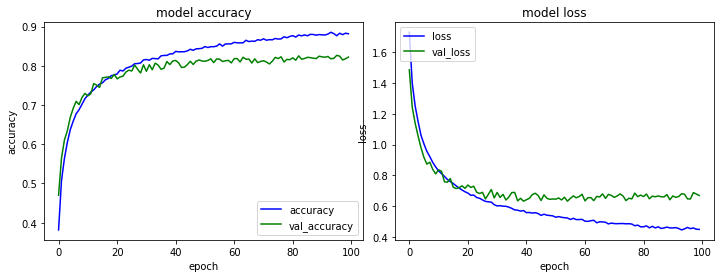

In [22]:
plot_history(history4.history)

In [23]:
# 学習結果を評価する。x_test_/255だとよくない。
test_loss, test_acc = model4.evaluate(x_test.astype('float32')/255, t_test_cat, verbose=0)
print(f'test_loss: {test_loss:.4f}  test_acc: {test_acc:.4f}')

test_loss: 2.7896  test_acc: 0.3332


In [25]:
# 学習結果を評価する。x_testのままでもよくない。
test_loss, test_acc = model4.evaluate(x_test.astype('float32'), t_test_cat, verbose=0)
print(f'test_loss: {test_loss:.4f}  test_acc: {test_acc:.4f}')

test_loss: 116.4364  test_acc: 0.2972
